In [19]:
# imports
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import joblib


In [20]:
# Variables
RANDOM_STATE = 42
TEST_SIZE = 0.3
TARGET_FEATURE = 'Label'
TARGET_FEATURE_MULTICLASS = 'Label_multiclass'
K_SPLIT = 5

kf = StratifiedKFold(n_splits=K_SPLIT, shuffle=True, random_state=RANDOM_STATE)

scoring = {'accuracy': 'accuracy','precision_macro': 'precision','recall_macro': 'recall','f1_macro': 'f1'}

In [21]:
# Load the data
df_train = pd.read_csv('data/hand_gesture_train.csv')
df_test = pd.read_csv('data/hand_gesture_test.csv')

# Split the data into X and y
train_X, test_X, train_y, test_y = train_test_split(df_train.drop([TARGET_FEATURE, TARGET_FEATURE_MULTICLASS], axis=1), df_train[TARGET_FEATURE], test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [22]:
# Define model pipelines
model = DecisionTreeClassifier(random_state=RANDOM_STATE)

In [23]:
# Hypertune using gridSearchCV
hyperparameters = {
    'max_depth': [None, 1, 3, 5, 10, 15],
    'min_samples_split': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
    'min_samples_leaf': [0.01, 0.05, 0.1, 0.3, 0.5],
    'criterion': ['gini', 'entropy', 'log_loss']
}

search = GridSearchCV(model, hyperparameters, cv=K_SPLIT, n_jobs=-1, scoring='accuracy')

search.fit(train_X, train_y)

print(f"Best parameters: {search.best_params_}")
print(f"Best score: {search.best_score_}")



Best parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01}
Best score: 0.8846153846153847


In [24]:
# Fit the model with the best params
model = DecisionTreeClassifier(**search.best_params_, random_state=RANDOM_STATE)

model.fit(train_X, train_y)

DecisionTreeClassifier(min_samples_leaf=0.01, min_samples_split=0.01,
                       random_state=42)

In [25]:
# Validate the model using cross validation
# Perform KFold cross-validation on the validation set
for score in scoring:
    scores = cross_val_score(model, test_X, test_y, cv=kf, scoring=score)
    print(f'____{score.split("_")[0]}___________________________________________')
    print(f'Cross-validation {score.split("_")[0]} on validation set: {scores}')
    print(f'{score.split("_")[0]} mean cross-validation score on validation set: {scores.mean():.2f}')
    print(f'{score.split("_")[0]} standard deviation on validation set: {scores.std():.2f}')

print("\n\n")



____accuracy___________________________________________
Cross-validation accuracy on validation set: [0.83333333 0.83333333 1.         1.         1.        ]
accuracy mean cross-validation score on validation set: 0.93
accuracy standard deviation on validation set: 0.08
____precision___________________________________________
Cross-validation precision on validation set: [0.83333333 0.88888889 1.         1.         1.        ]
precision mean cross-validation score on validation set: 0.94
precision standard deviation on validation set: 0.07
____recall___________________________________________
Cross-validation recall on validation set: [0.88888889 0.83333333 1.         1.         1.        ]
recall mean cross-validation score on validation set: 0.94
recall standard deviation on validation set: 0.07
____f1___________________________________________
Cross-validation f1 on validation set: [0.82222222 0.82222222 1.         1.         1.        ]
f1 mean cross-validation score on validation 

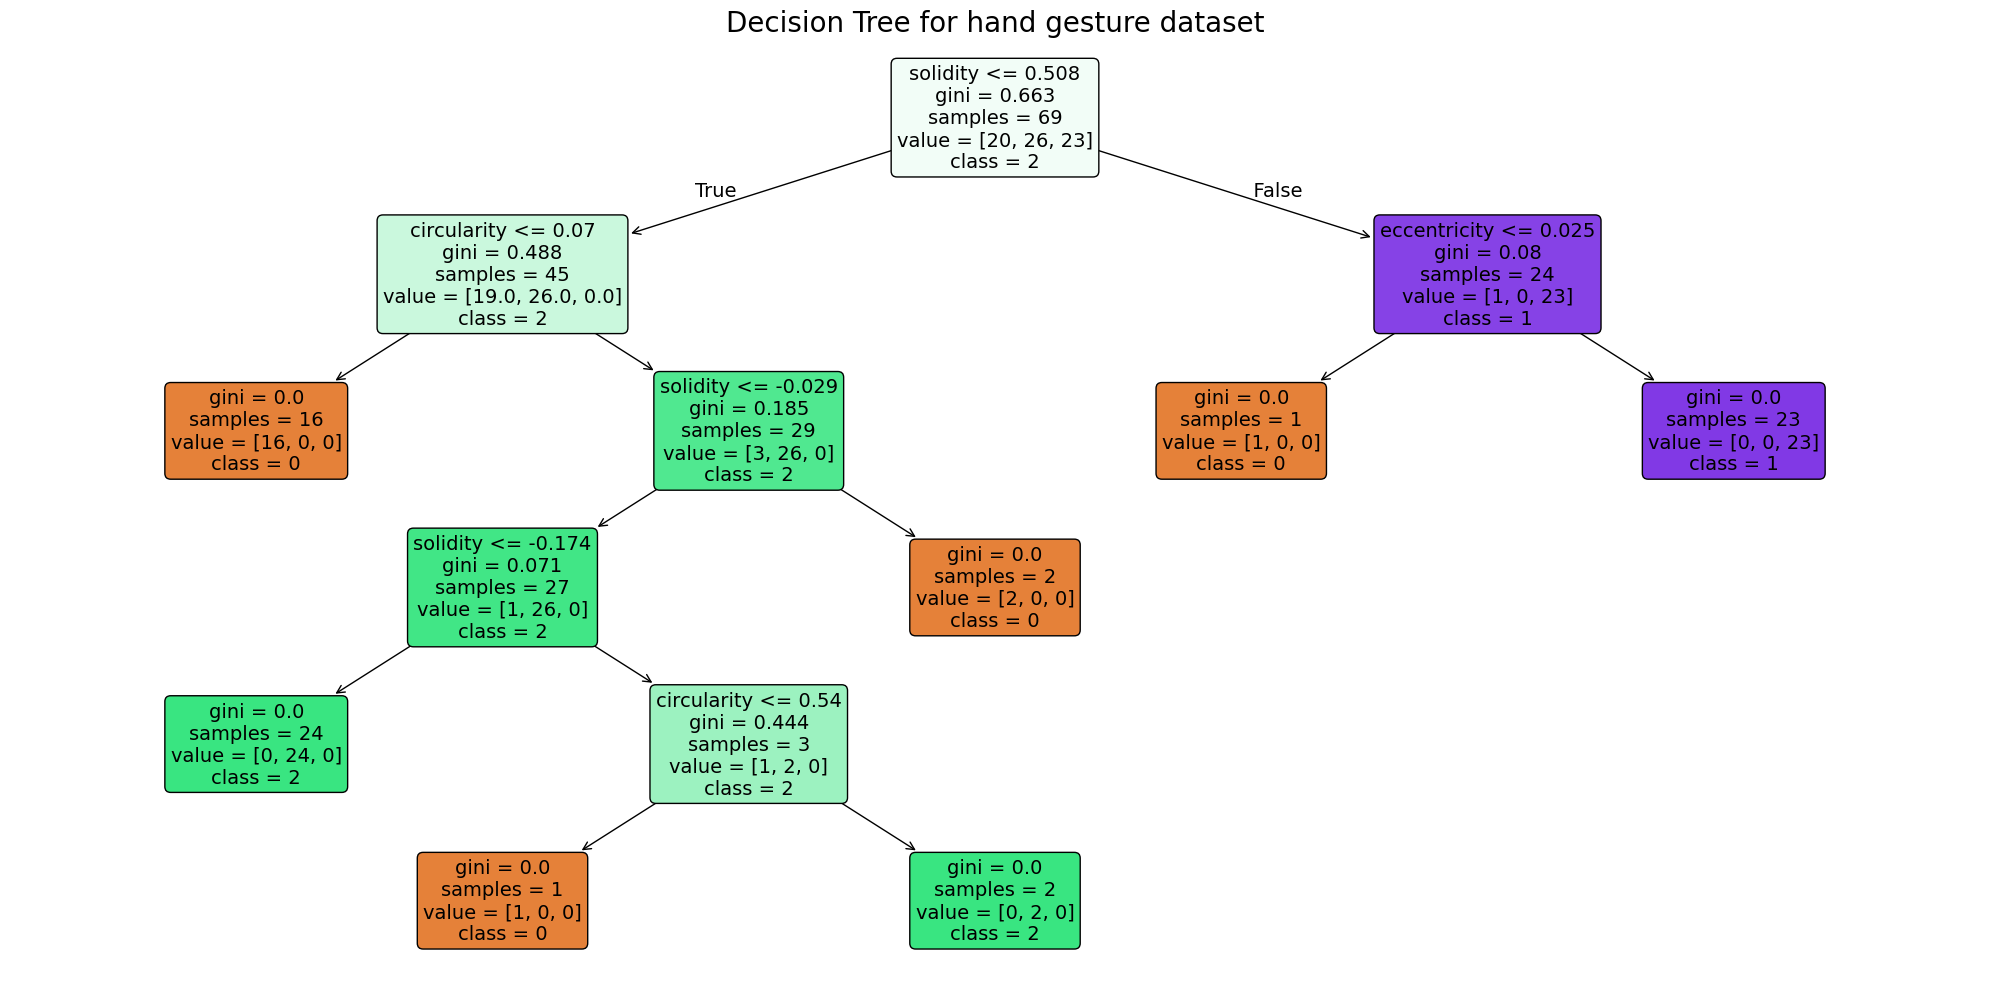

In [26]:
# Visualize the decision tree
plt.figure(figsize=(20,10))
tree.plot_tree(model, 
               feature_names=test_X.columns,
               class_names=test_y.unique().astype(str),
               filled=True, 
               rounded=True, 
               fontsize=14)
plt.title("Decision Tree for hand gesture dataset", fontsize=20)
plt.tight_layout()
plt.show()

In [27]:
# Test the model on the test set
y_pred = model.predict(df_test.drop([TARGET_FEATURE, TARGET_FEATURE_MULTICLASS], axis=1))
print(f"Accuracy: {accuracy_score(df_test[TARGET_FEATURE], y_pred)}")
print(f"Precision: {precision_score(df_test[TARGET_FEATURE], y_pred, average='macro')}")
print(f"Recall: {recall_score(df_test[TARGET_FEATURE], y_pred, average='macro')}")
print(f"F1: {f1_score(df_test[TARGET_FEATURE], y_pred, average='macro')}")
print(f"Confusion Matrix: \n{confusion_matrix(df_test[TARGET_FEATURE], y_pred)}")
print(f"Classification Report: \n{classification_report(df_test[TARGET_FEATURE], y_pred)}")
print("\n\n")

Accuracy: 0.8823529411764706
Precision: 0.8974358974358975
Recall: 0.8995098039215685
F1: 0.8849136526555882
Confusion Matrix: 
[[ 9  0  0]
 [ 3 14  0]
 [ 1  0  7]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.69      1.00      0.82         9
           1       1.00      0.82      0.90        17
           2       1.00      0.88      0.93         8

    accuracy                           0.88        34
   macro avg       0.90      0.90      0.88        34
weighted avg       0.92      0.88      0.89        34






In [28]:
# Export the model
joblib.dump(model, 'deployed/hand_gesture_decision_tree.pkl')

['deployed/hand_gesture_decision_tree.pkl']